# Проект E-commerce — Выявление профилей потребления

### Контекст
Интернет-магазин товаров для дома хочет сегментировать покупателей с целью создания персонализированных предложений для них и увеличения продаж. На данный момент бонусной программы нет.  

### Задача

Сегментировать покупателей по профилю потребления. Заказчик - менеджер продукта. 

### План работы
1. [Загрузить и подготовить данные к анализу](#step1)
   - [общая информация (пропуски, дубликаты, ошибки)](#step1.1)
   - [поиск и обработка выбросов в данных](#step1.2)
 

2. [Провести исследовательный анализ данных](#step2)
    - [Сезонность](#step2.1)
    - [Составление общей таблицы по клиентам](#step2.2)
    - [Выделение категорий товаров](#step2.3)
    - [Выводы](#step2.4)
    
    
3. [Сегментировать пользователей](#step3)      
   
4. [Проверить гипотезы методами статистики](#step4)
    - [Описание сегментов](#step4.1)
 
5. [Сделать выводы по сегментации пользователей](#step5)

**Ссылка на презентацию**:

https://yadi.sk/i/esra7UmcyHRrog


# 1. Загрузка данных и подготовка их к анализу <a id="step1"></a>   

## Общая информация <a id="step1.1"></a>

Загрузим библиотеки, датасет и посмотрим на базовую информацию о нем. 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import re
import math as mt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette('Set2')
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
transactions_raw = pd.read_csv('ecommerce_dataset.csv')
transactions_raw.head(10)
transactions_raw.info()
transactions_raw.duplicated().sum()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


0

На первый вгляд данные чистые, пропусков и явных дубликатов нет. Надо поменять тип данных `date` на `datetime`, `order_id` на `object`и `price` на `int`. Поменяем.
Также переименуем столбцы:
- `date` в `date_hour`, так как дата записана с часом,
- `product` в `product_name`, так как в pandas есть атрибут `product`, и иначе мы не сможем обращаться к столбцу через '.'

In [3]:
transactions_raw['date'] = pd.to_datetime(transactions_raw['date'], format='%Y%m%d%H')
transactions_raw['order_id'] = transactions_raw['order_id'].astype('object')
transactions_raw['price'] = transactions_raw['price'].astype(int)
transactions_raw = transactions_raw.rename(columns={'date':'date_hour', 'product':'product_name'})
transactions_raw.dtypes

date_hour       datetime64[ns]
customer_id             object
order_id                object
product_name            object
quantity                 int64
price                    int64
dtype: object

Посмотрим подробнее на товары. Приведем все к нижнему регистру и выведем несколько уникальных названий. 

In [4]:
transactions_raw['product_name'] = transactions_raw['product_name'].str.lower()
transactions_raw['product_name'].nunique()
transactions_raw['product_name'].unique()[:50]

2341

array(['комнатное растение в горшке алое вера, d12, h30',
       'комнатное растение в горшке кофе арабика, d12, h25',
       'радермахера d-12 см h-20 см', 'хризолидокарпус лутесценс d-9 см',
       'циперус зумула d-12 см h-25 см', 'шеффлера лузеана d-9 см',
       'юкка нитчатая d-12 см h-25-35 см',
       'настенная сушилка для белья gimi brio super 100',
       'таз пластмассовый 21,0 л круглый "водолей" с614, 1404056',
       'чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379',
       'вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, attribute, ahs331',
       'сушилка для белья потолочная zalger lift basic 1520 200 см, 10 м',
       'чехол eurogold clean basic хлопок для досок 120х38-120х42 см c42',
       'крючок одежный 2-х рожковый серый металлик с полимерным покрытием *тонар*, 1110027',
       'корзина мягкая пластиковая 17 л, м-пластика, m2880',
       'мини-сковорода marmiton "сердце" с антипригарным покрытием 12 см, lg17085',


Всего 2341 уникальных товара. Видно, что много комнатных растений, есть товары для кухни, хозяйственные мелочи, рассада, посуда и т.д. 

Потом посмотрим на базовую статистику по столбцам.

In [5]:
transactions_raw.describe(include='all', percentiles=[.75, .8, .85, .9, .95, .99])

,date_hour,customer_id,order_id,product_name,quantity,price
count,6737,6737,6737.0,6737,6737.000000,6737.000000
unique,2606,2451,2784.0,2341,NaN,NaN
top,2019-04-27 16:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833.0,рассада кабачка сорт зебра кассета 6 шт e6,NaN,NaN
freq,51,888,888.0,79,NaN,NaN
first,2018-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2019-10-31 16:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2.501559,462.028499
std,NaN,NaN,NaN,NaN,15.266478,871.296064
min,NaN,NaN,NaN,NaN,1.000000,9.000000
50%,NaN,NaN,NaN,NaN,1.000000,135.000000


In [6]:
transactions_raw.groupby('customer_id').order_id.nunique().describe()

count    2451.000000
mean        1.149327
std         2.655249
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       126.000000
Name: order_id, dtype: float64

Можно отметить, что:
- данные собраны за 13 месяцев - с 1 октября 2018 по 31 октября 2019,
- каждая строка представляет собой товарную единицу в заказе,
- в датасете 2451 клиент и 2784 уникальных заказа, что говорит о том, что клиенты почти не совершают повторных заказов,
- есть пользователь, у которого на один заказ приходится 888 единиц - надо исследовать подробнее: это один большой заказ или что-то еще, и есть ли другие такие пользователи;
- есть пользователь, у которого 126 заказов при том, что у подавляющего количества пользователей - только один;
- самый популярный товар - рассада кабачков.
- в среднем товары берут по одному, но какой-то товар взяли 1000 штук - исследовать подробнее.
- медианная стоимость товара - около 400 руб, и опять есть сильно отличающийся товар почти в 15 000 руб. 

Исследуем выбросы.

---
<div class="alert alert-block alert-success">

## Комментарий от наставника

Этот раздел отлично получился.
</div>

---

## Работа с выбросами <a id="step1.2"></a>

Проверим **самую часто встречающуюся дату**.

In [7]:
freq_date = transactions_raw.query('date_hour == @transactions_raw.date_hour.mode()[0]')
freq_date.describe(include='all')

,date_hour,customer_id,order_id,product_name,quantity,price
count,51,51,51.0,51,51.0,51.000000
unique,1,1,1.0,51,NaN,NaN
top,2019-04-27 16:00:00,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698.0,томата (помидор) этуаль №85 сорт детерминантны...,NaN,NaN
freq,51,51,51.0,1,NaN,NaN
first,2019-04-27 16:00:00,NaN,NaN,NaN,NaN,NaN
last,2019-04-27 16:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.0,57.294118
std,NaN,NaN,NaN,NaN,0.0,44.819770
min,NaN,NaN,NaN,NaN,1.0,38.000000
25%,NaN,NaN,NaN,NaN,1.0,38.000000


Похоже, на эту дату пришелся один заказ из 51 позиции. Возможно, это опт. Оставим.

Теперь **самый популярный пользователь**.

In [8]:
transactions_raw.query('customer_id==@transactions_raw.customer_id.mode()[0]').describe(include='all')

,date_hour,customer_id,order_id,product_name,quantity,price
count,888,888,888.0,888,888.000000,888.000000
unique,74,1,1.0,12,NaN,NaN
top,2019-06-03 10:00:00,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833.0,рассада огурец кристина ячейки по 6 шт е6,NaN,NaN
freq,12,888,888.0,74,NaN,NaN
first,2019-05-31 12:00:00,NaN,NaN,NaN,NaN,NaN
last,2019-06-22 06:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.013514,127.500000
std,NaN,NaN,NaN,NaN,0.115525,24.888704
min,NaN,NaN,NaN,NaN,1.000000,120.000000
25%,NaN,NaN,NaN,NaN,1.000000,120.000000


Итак, это пользователь, у которого прошел только один заказ из 888 позиций, хотя по времени этот заказ отмечался в системе 74 раза с 31 мая по 22 июня. Поскольку это даты проведения самого заказа (а не, например, просмотра корзины, что могло бы быть логично, если бы пользователь возвращался в корзину и ее изменял), то это больше похоже на какой-то сбой, так как на один заказ должна быть одна дата. Возможно есть проблема с дубликатами, особенно учитывая то, что даты указаны с часами. 

Сделаем сводную таблицу по заказам - `orders`, где выведем количество зафиксированных времен - `date_hour_unique`, первое - `date_hour_first` и последнее время - `date_hour_last`. Заодно посмотрим сумму заказа - `order_total`, количество уникальный продуктов в нем - `num_of_unique_products` и общее количество позиций в заказе - `quantity_sum`. Для того, чтобы исследовать проблему со временем заказа, добавим столбец с разницей между первым и последним временем - `difference`.

Для того, чтобы посчитать сумму заказа, добавим в основную таблицу столбец с суммарной стоимостью товарной позиции, учитывая ее количество - `total_price_per_product`.

---

<div class="alert alert-block alert-danger">
    

## Комментарий от наставника

Это отличная находка, но код с устранением дубликатов получился очень сложным. Давай просто удалим дубликаты заказов одного пользователя с помощью метода drop_duplicates.
</div>
    
---

*Упрощенный вариант:*

In [9]:
# transactions = transactions_raw.drop_duplicates(subset=['customer_id', 'order_id', 
#                                                         'product_name', 'quantity', 'price'])

In [10]:
transactions_raw['total_price_per_product'] = transactions_raw.quantity * transactions_raw.price
transactions_raw.head()

,date_hour,customer_id,order_id,product_name,quantity,price,total_price_per_product
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке алое вера, d12, h30",1,142,142
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"комнатное растение в горшке кофе арабика, d12,...",1,194,194
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d-12 см h-20 см,1,112,112
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d-9 см,1,179,179
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d-12 см h-25 см,1,112,112


*Вариант с исследованием проблемы с датами заказов по сводной таблице по заказам `orders`*:

In [11]:
orders = transactions_raw.pivot_table(index='order_id', 
                         values=['date_hour', 'total_price_per_product', 'product_name', 'quantity'], 
                         aggfunc={'date_hour':['nunique', 'first', 'last'],
                                   'total_price_per_product':'sum',
                                   'product_name':'nunique',
                                   'quantity':'sum'})
orders.columns = ['date_hour_first', 'date_hour_last', 'date_hour_unique',
                       'num_of_unique_products', 'quantity_sum', 'order_total']
orders['difference'] = orders.date_hour_last - orders.date_hour_first
orders.head()

,date_hour_first,date_hour_last,date_hour_unique,num_of_unique_products,quantity_sum,order_total,difference
order_id,,,,,,,
12624,2019-06-02 20:00:00,2019-06-02 20:00:00,1,2,2,375,0 days 00:00:00
13547,2018-10-05 00:00:00,2018-11-16 16:00:00,7,3,21,4788,42 days 16:00:00
14480,2018-10-02 11:00:00,2018-10-02 11:00:00,1,3,3,359,0 days 00:00:00
14481,2018-10-02 17:00:00,2018-10-02 17:00:00,1,4,4,600,0 days 00:00:00
14482,2018-10-07 12:00:00,2018-10-07 12:00:00,1,2,2,376,0 days 00:00:00


Теперь посмотрим статистику по ней.

In [12]:
orders.describe(percentiles=[.75, .8, .85, .9, .95, .99])

,date_hour_unique,num_of_unique_products,quantity_sum,order_total,difference
count,2784.000000,2784.000000,2784.000000,2784.000000,2784
mean,1.227730,1.730244,6.053520,1742.557471,0 days 14:04:34.137931
std,1.958941,2.795999,31.824985,13308.290654,5 days 20:50:15.442445
min,1.000000,1.000000,1.000000,14.000000,0 days 00:00:00
50%,1.000000,1.000000,1.000000,734.000000,0 days 00:00:00
75%,1.000000,1.000000,3.000000,1612.750000,0 days 00:00:00
80%,1.000000,1.000000,4.000000,1880.000000,0 days 00:00:00
85%,1.000000,1.000000,7.000000,2399.000000,0 days 00:00:00
90%,2.000000,3.000000,10.000000,3240.100000,0 days 01:00:00
95%,2.000000,6.000000,20.000000,4849.550000,0 days 20:00:00


In [13]:
orders.query('difference > "14 days"').describe()
orders.query('difference > "14 days"').sort_values(by='difference', ascending=False)

,date_hour_unique,num_of_unique_products,quantity_sum,order_total,difference
count,26.000000,26.000000,26.000000,26.000000,26
mean,9.846154,1.807692,51.807692,11946.192308,45 days 21:11:32.307692
std,17.649232,2.227451,174.360092,26414.826768,39 days 19:24:41.074455
min,2.000000,1.000000,2.000000,58.000000,14 days 17:00:00
25%,2.000000,1.000000,3.000000,626.250000,21 days 09:45:00
50%,3.000000,1.000000,9.000000,2061.000000,34 days 06:30:00
75%,6.750000,1.750000,26.250000,4778.000000,53 days 19:00:00
max,74.000000,12.000000,900.000000,114750.000000,209 days 18:00:00


,date_hour_first,date_hour_last,date_hour_unique,num_of_unique_products,quantity_sum,order_total,difference
order_id,,,,,,,
70960,2019-04-01 16:00:00,2019-10-28 10:00:00,60,1,60,65220,209 days 18:00:00
71663,2019-06-10 13:00:00,2019-09-05 12:00:00,4,1,4,536,86 days 23:00:00
69797,2019-01-12 20:00:00,2019-04-05 22:00:00,3,1,30,1770,83 days 02:00:00
69531,2018-12-23 14:00:00,2019-03-06 14:00:00,12,1,12,49668,73 days 00:00:00
71542,2019-05-28 21:00:00,2019-08-07 10:00:00,3,1,3,897,70 days 13:00:00
71054,2019-04-07 19:00:00,2019-06-05 09:00:00,5,1,50,2150,58 days 14:00:00
69310,2018-12-11 21:00:00,2019-02-03 22:00:00,4,1,28,1652,54 days 01:00:00
68814,2018-10-31 17:00:00,2018-12-23 18:00:00,2,2,5,252,53 days 01:00:00
71148,2019-04-15 12:00:00,2019-06-05 20:00:00,16,1,18,32382,51 days 08:00:00


Итак, **проблема в фиксировании времени действительно есть, и она встречается на 15% заказов.** Максимальная разница в одном и том же заказе - 209 дня. Однако, у 95% заказов эта разница не превышает сутки, а у 99% - две недели. Учитывая, что у нас данные за 13 месяцев, и большинство покупателей делают только один заказ, важно сохранить покупателей по максимому.

Поэтому **возьмем за выбросы заказы, где прошло больше 14 дней между первым и последним фиксированием заказа, и поставим первую дату как основную дату заказа**. Так мы уберем всего 1% заказов.

In [14]:
suspicious_orders = orders.query('difference > "14 days"').index
suspicious_orders

Int64Index([13547, 14521, 14833, 56879, 68476, 68814, 69162, 69310, 69381,
            69421, 69531, 69586, 69640, 69750, 69765, 69797, 69807, 70903,
            70946, 70960, 70962, 71054, 71148, 71542, 71663, 72403],
           dtype='int64', name='order_id')

In [15]:
transactions = transactions_raw.query('order_id not in @suspicious_orders')
transactions = transactions.merge(orders['date_hour_first'], on='order_id', how='left')
transactions.groupby('order_id').date_hour_first.nunique().mean()

1.0

Теперь на один заказ только одна дата. Уберем старый столбец `date_hour` и посмотрим на дубликаты.

In [16]:
transactions = transactions.drop('date_hour', axis=1)

transactions.duplicated().sum()

828

828 дубликатов. Уберем их и выведем информацию и базовую статистику уже на более чистом датасете.

In [17]:
transactions = transactions.drop_duplicates()
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4806 entries, 0 to 5632
Data columns (total 7 columns):
customer_id                4806 non-null object
order_id                   4806 non-null object
product_name               4806 non-null object
quantity                   4806 non-null int64
price                      4806 non-null int64
total_price_per_product    4806 non-null int64
date_hour_first            4806 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 300.4+ KB


In [18]:
transactions.describe(include='all', percentiles=[.75, .8, .85, .9, .95, .99])

,customer_id,order_id,product_name,quantity,price,total_price_per_product,date_hour_first
count,4806,4806.0,4806,4806.000000,4806.000000,4806.000000,4806
unique,2423,2758.0,2326,NaN,NaN,NaN,2177
top,c971fb21-d54c-4134-938f-16b62ee86d3b,14698.0,пеларгония розебудная red pandora укорененный ...,NaN,NaN,NaN,2019-04-27 16:00:00
freq,143,51.0,66,NaN,NaN,NaN,51
first,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-31 14:00:00
mean,NaN,NaN,NaN,2.843529,515.283812,853.811694,NaN
std,NaN,NaN,NaN,17.722584,945.303299,9874.792853,NaN
min,NaN,NaN,NaN,1.000000,9.000000,9.000000,NaN
50%,NaN,NaN,NaN,1.000000,150.000000,194.000000,NaN


У одного клиента 143 товарные позиции в одном или нескольких заказах. Соответственно, надо проверить распределение заказов по клиентам, чтобы выявить выбросы. Максимальное количество в 1000 штук товара и максимальная цена в 14917 тыс за штуку остались. Посмотрим на распределение количества товаров и цен, чтобы понять, стоит ли удалять эти выбросы.

Так как мы хотим использовать KMeans для сегментации, а также посмотреть разницу по средним, выбросы надо будет удалить, потому что KMeans к ним чувствителен.

Начнем с **распределения заказов по клиентам**.

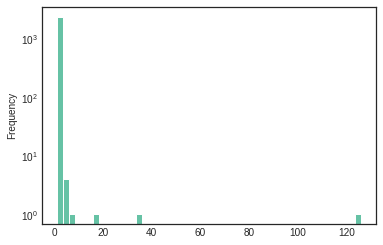

In [19]:
_ = transactions.groupby('customer_id').order_id.nunique().plot(kind='hist', logy=True, bins=50)

Видны выбросы после 10 заказов. Посмотрим детально. 

In [20]:
transactions.groupby('customer_id').order_id.nunique().sort_values(ascending=False)

customer_id
c971fb21-d54c-4134-938f-16b62ee86d3b    126
4d93d3f6-8b24-403b-a74b-f5173e40d7db     35
73d1cd35-5e5f-4629-8cf2-3fda829d4e58     17
b7b865ab-0735-407f-8d0c-31f74d2806cc      7
0184f535-b60a-4914-a982-231e3f615206      5
                                       ... 
abedd6ad-e720-431b-8ea2-a1d58008165b      1
abeada3e-b1b7-48e6-b416-4acf56f24898      1
abdc17c8-0813-4b05-9e10-1ffc77eea2d8      1
ab938608-1b5b-4830-9fc0-dfc649c04b2f      1
000d6849-084e-4d9f-ac03-37174eaf60c4      1
Name: order_id, Length: 2423, dtype: int64

Действительно, после 7 заказов только у трех клиентов 17, 35 и 126 заказов. Посчитаем это выбросами и удалим этих клиентов.

In [21]:
max_customers = transactions.groupby('customer_id').order_id.nunique()\
                                                   .sort_values(ascending=False).index[:2].to_list()

In [22]:
transactions = transactions.query('customer_id != @max_customers')
transactions.customer_id.nunique()
transactions.groupby('customer_id').order_id.nunique().describe()

2421

count    2421.000000
mean        1.083437
std         0.465835
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        17.000000
Name: order_id, dtype: float64

Смотрим **количество товаров**.

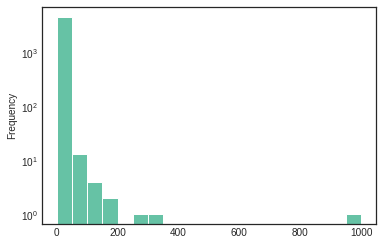

In [23]:
_ = transactions.quantity.plot(kind='hist', logy=True, bins=20)

In [24]:
transactions.query('quantity > 200')

,customer_id,order_id,product_name,quantity,price,total_price_per_product,date_hour_first
3802,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51,15300,2019-05-20 21:00:00
4362,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148,49432,2019-06-11 07:00:00
4445,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675,675000,2019-06-18 15:00:00


Количество товара больше 200 - явные выбросы. Это всего три клиента, удалим их.

In [25]:
transactions = transactions.query('quantity < 200')

Теперь **цены отдельно взятых товаров**.

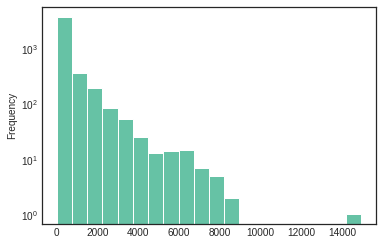

In [26]:
_ = transactions.price.plot(kind='hist', logy=True, bins=20)

In [27]:
transactions.query('price > 8000')

,customer_id,order_id,product_name,quantity,price,total_price_per_product,date_hour_first
1874,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437,8437,2019-02-24 10:00:00
2579,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737,8737,2019-04-05 19:00:00
2861,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077,8077,2019-04-21 16:00:00
4910,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917,14917,2019-07-29 17:00:00


Тут можно обозначить один явный выброс - те самые 14917, это всего один заказ. Тоже удалим.

In [28]:
transactions = transactions.query('price < @transactions.price.max()')

Посмотрим на окончательную статистику.

In [29]:
transactions.info()
transactions.describe(include='all', percentiles=[.75, .8, .85, .9, .95, .99])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4613 entries, 0 to 5632
Data columns (total 7 columns):
customer_id                4613 non-null object
order_id                   4613 non-null object
product_name               4613 non-null object
quantity                   4613 non-null int64
price                      4613 non-null int64
total_price_per_product    4613 non-null int64
date_hour_first            4613 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 288.3+ KB


,customer_id,order_id,product_name,quantity,price,total_price_per_product,date_hour_first
count,4613,4613.0,4613,4613.000000,4613.000000,4613.000000,4613
unique,2416,2592.0,2249,NaN,NaN,NaN,2091
top,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698.0,пеларгония розебудная red pandora укорененный ...,NaN,NaN,NaN,2019-04-27 16:00:00
freq,51,51.0,64,NaN,NaN,NaN,51
first,NaN,NaN,NaN,NaN,NaN,NaN,2018-10-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-31 14:00:00
mean,NaN,NaN,NaN,2.425320,497.890527,677.690007,NaN
std,NaN,NaN,NaN,7.571623,912.778273,1529.288784,NaN
min,NaN,NaN,NaN,1.000000,9.000000,9.000000,NaN
50%,NaN,NaN,NaN,1.000000,150.000000,188.000000,NaN


In [30]:
transactions.customer_id.nunique()/transactions_raw.customer_id.nunique()
transactions.order_id.nunique()/transactions_raw.order_id.nunique()

0.9857201142390861

0.9310344827586207

## Итого

Была обнаружена проблема с датами - на один и тот же заказ приходилось несколько дат, разница между которыми у 95% заказов эта разница не превышает сутки, а у 99% - две недели, с максимальной разницей в 209 дней. Было решено удалить заказы, где разница превышала две недели, а оставшимся поставить первую дату как основну. О данной проблеме необходимо сообщить тем, кто собирает статистику на сайте. 

Кроме того, обнаружилось 3 клиента, с количеством заказов, сильно превышающих среднее (17, 35 и 126). Их удалили.
Также были удалены заказы, где количество товарных единиц превышает 200 штук, и самый дорогой заказ в примерно в 15000 руб. 
Мы удалили меньше 2% клиентов и около 7% заказов. Данные готовы к анализу.

# 2. Исследовательский анализ данных <a id="step2"></a> 

## Сезонность <a id="step2.1"></a>

Посмотрим, есть ли **сезонность**. Добавим столбец с месяцем - `month`и построим столбчатые диаграммы по количеству уникальных пользователей, заказов и сумме заказа.

In [31]:
transactions['month'] = transactions['date_hour_first'].astype('datetime64[M]')
transactions.dtypes

customer_id                        object
order_id                           object
product_name                       object
quantity                            int64
price                               int64
total_price_per_product             int64
date_hour_first            datetime64[ns]
month                      datetime64[ns]
dtype: object

In [32]:
order_by_month = transactions.groupby('month').agg({'customer_id':'nunique', 'order_id':'count', 
                                                    'total_price_per_product':'sum'})
order_by_month.columns = ['num_of_customers', 'num_of_orders', 'revenue']
order_by_month['revenue_per_customer'] = order_by_month.revenue / order_by_month.num_of_customers
order_by_month

,num_of_customers,num_of_orders,revenue,revenue_per_customer
month,,,,
2018-10-01,176,404,263187,1495.380682
2018-11-01,176,395,334107,1898.335227
2018-12-01,230,267,299621,1302.700000
2019-01-01,146,173,218099,1493.828767
2019-02-01,243,332,259118,1066.329218
2019-03-01,234,408,247324,1056.940171
2019-04-01,234,672,313559,1339.995726
2019-05-01,167,720,221372,1325.580838
2019-06-01,151,291,178214,1180.225166


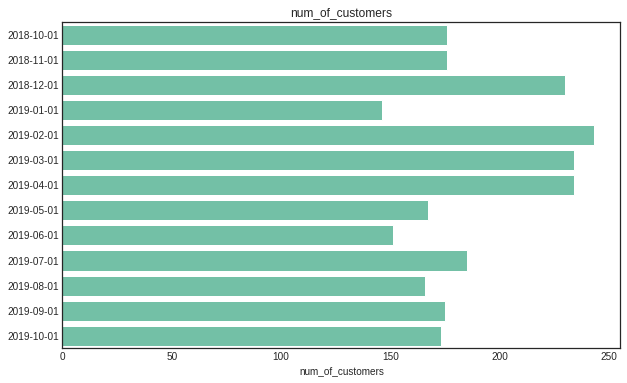

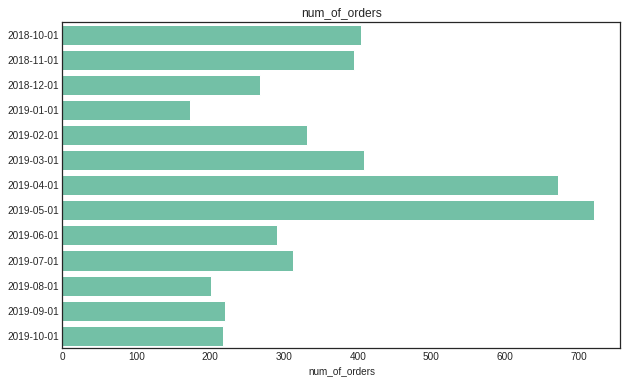

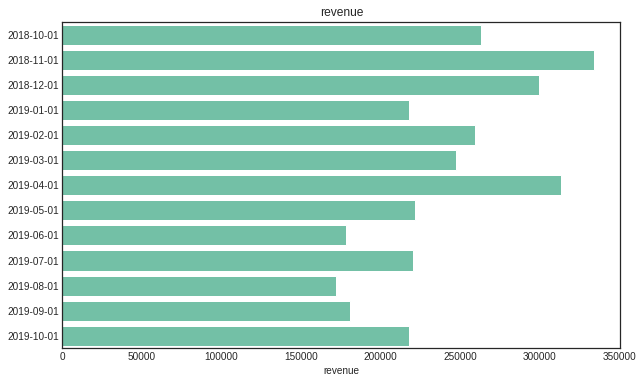

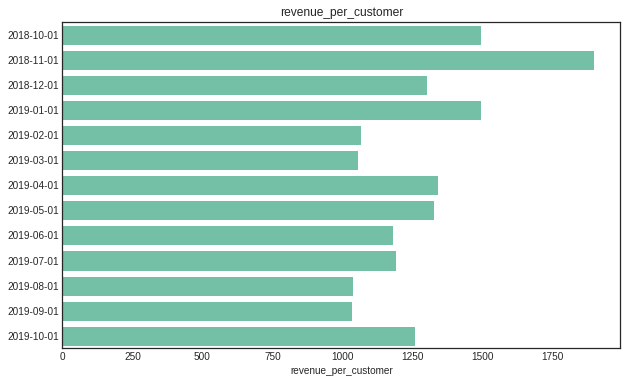

In [33]:
for col in order_by_month.columns.to_list():
    _ = plt.figure(figsize=(10, 6))
    _ = sns.barplot(data=order_by_month, y=order_by_month.index.strftime('%Y-%m-%d'), x=col, color='mediumaquamarine')
    _ = plt.title(col)
    plt.show()

---

<div class="alert alert-block alert-danger">
    

## Комментарий от наставника

Убери, пожалуйста, цвета с графиков. Некоторые коллеги будут спрашивать что значат цвета и искать легенду.
</div>
    
---

По графикам можно сказать, что
- по количеству клиентов выделились декабрь 2018, февраль, март и апрель 2019 года. Меньше всего было в январе и в июне 2019;
- по количеству заказов лидируют апрель и май 2019 (как минимум на треть), меньше всего - в январе 2019, декабре 2018 и июне 2019. В общем можно заметить уменьшение количества заказов за год;
- по суммарной выручке в месяц выделяются ноябрь и декабрь 2018, а также апрель 2019. Тоже имеется тенденция к снижению. Самые низкие показатели были в июне, августе и сентябре 2019;
- по средней выручке на клиента в месяц лидирует ноябрь 2018, после него идут октябрь и декабрь 2018. Меньше всего в феврале, марте, августе и сентябре 2019. 

Таким образом, можно сказать, что весной клиенты более активны, а летом менее. С другой стороны, данные у нас всего за год, и повторных покупок очень мало. Соответственно, однозначно отследить сезонность сложно. Не будем использовать ее для сегментации.

## Сводная по клиентам <a id="step2.2"></a>

Соберем **сводную таблицу по клиентам**.

Сначала сделаем сводную по клиентам и заказам `customers_orders`. Добавим количество уникальных продуктов на заказ - `unique_products`, количество всех продуктов в заказе - `total_quantity` и сумму заказа - `total_sum`. Затем добавим среднее количество каждого товара `avg_num_product` и среднюю стоимость товара `avg_product_price`.

In [34]:
customers_orders = transactions.groupby(['customer_id', 'order_id']).agg({'product_name':'nunique',
                                                                   'quantity':'sum',
                                                                   'total_price_per_product':'sum'}).reset_index()
customers_orders = customers_orders.rename(columns={'product_name':'unique_products', 
                                                    'total_price_per_product':'total_sum',
                                                    'quantity':'total_quantity'})
customers_orders['avg_num_product'] = customers_orders.total_quantity / customers_orders.unique_products
customers_orders['avg_product_price'] = customers_orders.total_sum / customers_orders.total_quantity
customers_orders

,customer_id,order_id,unique_products,total_quantity,total_sum,avg_num_product,avg_product_price
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,4,4,555,1.0,138.75
1,001cee7f-0b29-4716-b202-0042213ab038,70290,1,1,442,1.0,442.00
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,1,2,914,2.0,457.00
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1,1,1649,1.0,1649.00
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,1,2,2324,2.0,1162.00
...,...,...,...,...,...,...,...
2613,ff601403-b094-4b86-9ac6-264d725b9277,72313,1,1,1649,1.0,1649.00
2614,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,1,1,397,1.0,397.00
2615,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,69369,1,1,389,1.0,389.00
2616,ffb80538-3fda-4351-8ea9-9d2bec58bb07,72561,1,1,974,1.0,974.00


Теперь объединим заказы по клиентам - `customers`. Посчитаем:
- количество заказов на каждого клиента - `num_of_orders`, 
- среднее количество уникальных продуктов - `avg_unique_prod`, 
- среднее количество всех продуктов на заказ - `avg_quantity`, 
- общую выручку по клиенту - `total_sum`, 
- среднее количество уникальных продуктов - `avg_num_product`
- среднюю стоимость отдельно взятого продукта - `avg_product_price`. 
- Потом добавим среднюю выручку на один заказ - `revenue_per_order`. 

Выведем базовую статистику.

In [35]:
customers = customers_orders.groupby('customer_id').agg({'order_id':'count',
                                                         'unique_products':'mean',
                                                         'total_quantity':'mean',
                                                         'total_sum':'sum',
                                                         'avg_num_product':'mean',     
                                                         'avg_product_price':'mean'}).reset_index()


customers['revenue_per_order'] = customers.total_sum/ customers.order_id
customers = customers.rename(columns={'order_id':'num_of_orders',
                                      'unique_products':'avg_unique_prod', 
                                      'total_quantity':'avg_quant_per_order', 
                                      'total_sum':'total_revenue'})
customers
customers.describe(percentiles=[.75, .8, .85, .9, .95, .99])

,customer_id,num_of_orders,avg_unique_prod,avg_quant_per_order,total_revenue,avg_num_product,avg_product_price,revenue_per_order
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4.0,4.0,555,1.0,138.75,555.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1.0,1.0,442,1.0,442.00,442.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1.0,2.0,914,2.0,457.00,914.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1.0,1649,1.0,1649.00,1649.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1.0,2.0,2324,2.0,1162.00,2324.0
...,...,...,...,...,...,...,...,...
2411,ff601403-b094-4b86-9ac6-264d725b9277,1,1.0,1.0,1649,1.0,1649.00,1649.0
2412,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,1.0,1.0,397,1.0,397.00,397.0
2413,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,1.0,1.0,389,1.0,389.00,389.0
2414,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,1.0,1.0,974,1.0,974.00,974.0


,num_of_orders,avg_unique_prod,avg_quant_per_order,total_revenue,avg_num_product,avg_product_price,revenue_per_order
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000
mean,1.083609,1.736785,4.267549,1293.950331,3.128685,768.514663,1190.486894
std,0.466302,2.881070,11.781473,2360.263899,9.608966,1118.161325,1871.514319
min,1.000000,1.000000,1.000000,14.000000,1.000000,14.000000,14.000000
50%,1.000000,1.000000,1.000000,711.000000,1.000000,342.250000,674.000000
75%,1.000000,1.000000,3.000000,1574.000000,1.500000,974.000000,1435.500000
80%,1.000000,1.000000,4.000000,1799.000000,2.000000,1087.000000,1649.000000
85%,1.000000,1.000000,6.000000,2235.500000,3.000000,1574.000000,2025.000000
90%,1.000000,3.000000,10.000000,2849.500000,5.000000,1912.000000,2699.000000
95%,2.000000,6.000000,17.625000,3990.500000,10.000000,2942.750000,3781.000000


Итак, готова таблица для сегментирования пользователей по количественным критериям. Теперь в нее надо добавить, какие категории товара они покупают.

Пока можно сказать, что очень усредненно на одного клиента приходится один заказ, в нем один товар. Средняя стоимость товара - 340 р., а средняя выручка - 700 р. Однако видно, что минимальные и максимальные значения существенно разнятся, и именно для этого нужна сегментация 

## Выделение категорий товаров <a id="step2.3"></a>

Логично предположить, что клиентов можно также сегментировать по тому, какие товары они берут. Для выделения категорий преобразуем имена товаров и вынесем это в отдельный столбец `product_name_short`. 

Учитывая, что, как правило, названия товаров - существительные (и здесь они на русском языке, не учитывая название бренда), мы сначала почистим строки от того написано латиницей, от цифр и пунктуации. Затем удалим слова, которые имеют типичные окончания прилагательных (-ый, -ое, и тд). Конечно, сюда могут попасть существительные, но таких немного. 

In [36]:
transactions['product_name_short'] = transactions.product_name.str\
       .replace('[0-9a-z,()*%№/]', '', regex=True).str.replace('["-]', ' ').str.strip()

In [37]:
transactions['product_name_short'] = transactions.product_name_short.str\
.replace('\w+ое\s|\w+ая\s|\w+ый\s|\w+вой\s|\w+кой\s|\w+ий\s|\w+яя\s|\w+ей\s|\w+ым\s|\w+ее\s|\w+их\s', '', regex=True)
transactions.product_name_short.unique()[:20]

array(['растение в горшке вера', 'растение в горшке кофе арабика',
       'радермахера   см   см', 'хризолидокарпус лутесценс   см',
       'циперус зумула   см   см', 'шеффлера лузеана   см',
       'юкка   см    см', 'сушилка для белья', 'таз  л   с',
       'вешалка для брюк с покрытием  см цвет: синяя',
       'сушилка для белья      см  м',
       'крючок  х металлик с покрытием тонар', 'корзина  л м пластика',
       'доска   х см сетка', 'растение тимьян чабрец объем  л',
       'рассада зелени для кухни базилик тонус кассета по шт',
       'рассада зелени для кухни мелиссы в горшке диам.  см',
       'муляж  райские яблочки зеленые   шт полиуретан   см',
       'муляж банан  см полиуретан',
       'муляж виноград  см цвет в ассортименте'], dtype=object)

Теперь можно заметить, что первое слово как раз и определяет сущность товара. Оставим только его и выведем уникальные значения, которые потом распределим вручную по категориям. 

In [38]:
transactions['product_name_short'] = transactions['product_name_short'].str.split(' ').str[0]
transactions['product_name_short'] = transactions['product_name_short'].apply(lambda x: re.sub(r'\s+', ' ', x))
transactions[['product_name', 'product_name_short']].head(10)
transactions.product_name_short.sort_values().unique()

,product_name,product_name_short
0,"комнатное растение в горшке алое вера, d12, h30",растение
1,"комнатное растение в горшке кофе арабика, d12,...",растение
2,радермахера d-12 см h-20 см,радермахера
3,хризолидокарпус лутесценс d-9 см,хризолидокарпус
4,циперус зумула d-12 см h-25 см,циперус
5,шеффлера лузеана d-9 см,шеффлера
6,юкка нитчатая d-12 см h-25-35 см,юкка
7,настенная сушилка для белья gimi brio super 100,сушилка
8,"таз пластмассовый 21,0 л круглый ""водолей"" с61...",таз
10,вешалка для брюк металлическая с резиновым пок...,вешалка


array(['агератум', 'адиантум', 'азалия', 'аквилегия', 'алиссум', 'алоэ',
       'альбука', 'амариллис', 'анемона', 'антижир', 'антинакипин',
       'антуриум', 'аптения', 'арбуз', 'аргирантерум', 'артемизия',
       'аспарагус', 'астра', 'афеляндра', 'бадан', 'базилик', 'бак',
       'баклажан', 'бакопа', 'бальзам', 'бальзамин', 'банка', 'барвинок',
       'бархатцы', 'бегония', 'белье', 'бельевые', 'бензин', 'бидон',
       'биопорошок', 'блок', 'блюдо', 'блюдце', 'буддлея', 'бузульник',
       'бульонница', 'в', 'ваза', 'валериана', 'ванна', 'вантуз', 'ведро',
       'веник', 'венчик', 'вербейник', 'вербена', 'веревка', 'вероника',
       'весы', 'вешалка', 'вешалки', 'вигна', 'вилка', 'виноград',
       'виола', 'вкладыши', 'газания', 'гайлардия', 'гардения',
       'гвоздика', 'гель', 'георгина', 'герань', 'гербера', 'гиацинт',
       'гимнокалициум', 'гиностемма', 'гипсофила', 'глоксиния', 'годеция',
       'горох', 'гортензия', 'губка', 'декабрист', 'дендробиум', 'дерево',
      

Можно выделить 12 категорий:
- Домашние растения - `plants`,
- Семена и саженцы - `seedlings`, 
- Садовые цветы - `flowers`, 
- Товары для кухни - `kitchen`, 
- Товары для ванной - `bathroom`, 
- Товары для спальной - `bedroom`, 
- Электробытовые приборы - `appliances`, 
- Предметы мебели - `furniture`, 
- Товары для дома - `house_object`, 
- Товары для сада - `garden_objects`, 
- Сумки и контейнеры - `containers`, 
- Инструменты - `tools`. 

In [39]:
plants = ['растение', 'агератум', 'адиантум', 'азалия', 'аквилегия', 'алиссум', 'алоэ', 'альбука', 'амариллис', 
         'анемона', 'антуриум', 'аптения', 'артемизия', 'аргирантерум','аспарагус', 'афеляндра', 
         'бальзамин', 'газания', 'гайлардия', 'гардения', 'гиацинт', 'гимнокалициум', 'гиностемма', 'гипсофила', 
         'глоксиния', 'годеция','замиокулькас','дендробиум','джункус', 'диффенбахия', 'импатиенс', 'калатея', 
         'калибрахоа', 'калла', 'каллуна', 'калоцефалус', 'кореопсис', 'крассула', 'декабрист', 
         'драцена', 'кампанула', 'капсикум', 'бегония', 'кодонанта', 'колеус','герань', 'гербера',
         'радермахера', 'ранункулус', 'синнингия', 'спатифиллум','суккулент','сциндапсус', 'тагетис','фаленопсис',
         'фиалка', 'физостегия', 'фикус','фиттония', 'флокс', 'фуксия', 'хамедорея','хлорофитум','хризантема', 
         'хризолидокарпус', 'целозия', 'цинерария','циния', 'цинния', 'циперус', 'цитрофортунелла','энотера', 
         'эпипремнум','эхеверия', 'эхинацея', 'эхинокактус', 'эшшольция', 'юкка', 'ясколка', 'муррайя', 'пеперомия', 
         'пиретрум','цикламен', 'цинерания', 'крассула', 'лантана', 'лапчатка', 'литопс', 'лобелия',
         'мединилла','мимоза', 'мирт', 'пахира', 'пеларгония', 'петуния', 'платикодон', 'примула', 
         'пуансетия', 'пуансеттия', 'рудбекия', 'головник', 'джункус', 'каландива', 'калибрахо','кипарисовик', 
         'колокольчик', 'осмея',  'лаватера', 'лавр', 'лиана', 'маттиола', 'нивянник', 'нолина', 
         'папоротник', 'сальвия', 'седум', 'смолевка','соланум', 'фатсия', 'цветок', 'шеффлера'] 

seedlings = ['арбуз','баклажан','капуста','дыня', 'кабачок', 'огурец','патиссон', 'тыква', 'клубника', 'рассада',
         'томат', 'томата', 'эвкалипт', 'виноград', 'клен', 'дерево', 'ель', 'осина', 'душица', 'кориандр', 'базилик', 
         'валериана', 'горох', 'зев', 'мята', 'розмарин', 'мелисса', 'морковь','тимьян', 'укроп', 'петрушка', 'чабер', 
         'лук', 'нектар', 'любисток', 'пряные', 'кофе', 'космея', 'подсолнечник', 'сельдерей', 'шалфей']

flowers = ['астра', 'бархатцы', 'гортензия','календула','земляника', 'бузульник', 'бадан', 'бакопа', 'вербейник',
         'бальзамин', 'настурция', 'роза', 'вероника', 'вигна', 'гвоздика', 'тюльпан', 'лаванда', 'георгина', 
         'крокусы', 'гортензия', 'незабудка', 'барвинок', 'буддлея', 'виола', 'овсянница', 'вербена', 'камнеломка',
         'кореопсис','лен', 'молодило', 'монарда', 'мускари', 'оптимист', 'портулак', 'солидаго', 'хоста', 'лилейник', 
         'зверобой', 'змееголовник', 'котовник', 'табак']    

kitchen = ['антижир', 'антинакипин', 'картофелемялка', 'кастрюля', 'венчик', 'вилка', 'блюдо', 'блюдце',
         'бульонница', 'бидон', 'кипятильник', 'губка', 'измельчитель', 'кружка','кувшин',
         'кухонные', 'ложка', 'лопатка', 'мантоварка', 'масленка', 'миска', 'мокружка', 'нож', 'ножеточка', 
         'овощеварка', 'овощечистка', 'салфетка', 'салфетница', 'сахарница', 'сотейник', 'орехоколка', 'отделитель', 
         'половник','просеиватель', 'противень', 'рыбочистка', 'салат', 'салатник', 'сито','скалка', 'скатерть', 
         'сковорода', 'стакан', 'тарелка', 'терка', 'термокружка', 'термос', 'термостакан', 'толкушка', 'тортница',
         'форма','хлебница', 'лоток','электроштопор', 'тряпка', 'емкость',
         'вкладыши','комплект', 'концентрат', 'крышка', 'набор', 'шприц', 'нетканые', 'пресс', 'рассекатель', 
         'соль', 'средство', 'экран', 'бальзам', 'перчатки']  

bathroom = ['бак', 'биопорошок', 'ванна', 'вантуз', 'ерш', 'ведро', 'бельевые', 'веник', 'веревка',
         'дозатор', 'кондиционер','мыло', 'мыльница','ополаскиватель','отбеливатель', 'полотенце', 'прищепки',
         'сушилка', 'таз', 'швабра', 'щетка', 'щётка', 'ёрш', 'гель', 'ковш', 'халат', 'держатель', 'крем','маска', 
         'насадка','отжим','паста', 'пена', 'пробка', 'совок', 'штора', 'сиденье', 'карниз', 'штанга', 'подголовник']

bedroom = ['наволочка', 'наматрасник', 'наматрацник', 'наматрицник', 'одеяло', 'пододеяльник', 'подушка', 'покрывало',
         'простынь', 'простыня', 'белье' ]

appliances = ['весы', 'термометр', 'утюг', 'фен', 'пылесос', 'чайник', 'миксер', 'соковарка', 'соковыжималка']

furniture = ['комод', 'обувница', 'полка', 'этажерка', 'пуф', 'стеллаж', 'полки']

house_object = ['вешалка', 'вешалки', 'ваза', 'доска', 'подкладка', 'подрукавник', 'рукав', 'покрытие', 'кашпо', 
         'ключница', 'фоторамка', 'ковер', 'коврик', 'ковёр', 'плед', 'плечики', 'сетка', 
         'муляж', 'композиция','лист', 'окномойка', 'чехол']

garden_objects = ['лестница', 'стремянка', 'стремянки', 'тележка', 'котел', 'урна', 'корыто']

containers = ['контейнер',  'нер', 'пакет', 'корзина', 'корзинка', 'короб', 'коробка', 'подставка', 
              'сумка',  'кофр', 'мешок', 'ящик', 'банка',   'таз']

tools = ['кольца', 'завертка', 'крепеж', 'петля', 'сверло','скребок', 'сметка', 'стяжка', 'стяжки', 'фиксатор', 
         'шило', 'шпингалет',  'штангенциркуль', 'основание', 'бензин', 'пружина', 'пьезозажигалка', 
         'сварка',  'угольник', 'шнур', 'шпагат', 'фал', 'ткань', 'тряпкодержатель', 'решетка', 'ролик', 
         'блок', 'ручка', 'уголок', 'крючок', 'линейка']

Создадим столбец категории с базовым именем `Другое`, а потом поменяем его в зависимости от содержания столбца `product_name_short`, используя составленные списки.

In [40]:
transactions['category'] = 'Другое'
transactions.loc[transactions.query('product_name_short in @plants').index, 'category'] = 'Домашние растения'
transactions.loc[transactions.query('product_name_short in @seedlings').index, 'category'] = 'Семена и саженцы'
transactions.loc[transactions.query('product_name_short in @flowers').index, 'category'] = 'Садовые цветы'
transactions.loc[transactions.query('product_name_short in @kitchen').index, 'category'] = 'Товары для кухни'
transactions.loc[transactions.query('product_name_short in @bathroom').index, 'category'] = 'Товары для ванной'
transactions.loc[transactions.query('product_name_short in @bedroom').index, 'category'] = 'Товары для спальной'
transactions.loc[transactions.query('product_name_short in @appliances').index, 'category'] = 'Электробытовые приборы'
transactions.loc[transactions.query('product_name_short in @furniture').index, 'category'] = 'Предметы мебели'
transactions.loc[transactions.query('product_name_short in @house_object').index, 'category'] = 'Товары для дома'
transactions.loc[transactions.query('product_name_short in @garden_objects').index, 'category'] = 'Товары для сада'
transactions.loc[transactions.query('product_name_short in @containers').index, 'category'] = 'Сумки и контейнеры'
transactions.loc[transactions.query('product_name_short in @tools').index, 'category'] = 'Инструменты'
transactions['category'].value_counts()

Домашние растения         1516
Семена и саженцы           776
Товары для дома            613
Товары для ванной          478
Сумки и контейнеры         376
Товары для кухни           356
Садовые цветы              203
Товары для сада            149
Инструменты                 54
Предметы мебели             36
Электробытовые приборы      34
Товары для спальной         18
Другое                       4
Name: category, dtype: int64

In [41]:
for cat in transactions.category.unique():
    cat
    transactions.query('category in @cat').product_name.value_counts()[:5]

'Домашние растения'

пеларгония розебудная red pandora укорененный черенок      64
пеларгония розебудная prins nikolai укорененный черенок    53
пеларгония зональная диам. 12 см сиреневый полумахровый    52
пеларгония розебудная mary укорененный черенок             39
пеларгония розебудная queen ingrid укорененный черенок     30
Name: product_name, dtype: int64

'Товары для ванной'

сушилка для белья настенная zalger prima 510-720 веревочная 7 линий 25 м    16
сушилка для белья потолочная лиана 2,0 м 1703009                            10
сушилка для белья напольная ника сбп1/с 18 м                                 9
сушилка для белья потолочная лиана 2,4 м 1703011                             8
сиденье в ванну раздвижное, белый, св5, ника                                 7
Name: product_name, dtype: int64

'Сумки и контейнеры'

сумка-тележка 2-х колесная gimi argo синяя                     42
таз пластмассовый со стиральной доской (иж), 1404021           10
сумка-тележка 2-х колесная складная gimi flexi зеленая          9
сумка-тележка 2-х колесная gimi argo красная                    8
сумка для тележки большая комбинированная 45*30*25, 1209021     8
Name: product_name, dtype: int64

'Товары для дома'

муляж яблоко зеленый 9 см полиуретан           10
муляж баклажан 18 см                           10
муляж персики мини полиуретан d-6 см            9
муляж красное яблоко мини полиуретан d-6 см     8
муляж зеленое яблоко полиуретан d-6 см          7
Name: product_name, dtype: int64

'Инструменты'

стяжка оконная с болтом ст-55 цинк, 1108354               4
крепеж для пружины дверной, 1107055                       2
шнур резиновый для тележки 80 см, 1209001                 2
тряпкодержатель с металлическим креплением (г) 1804015    2
бензин для зажигалок, 1205214                             2
Name: product_name, dtype: int64

'Семена и саженцы'

рассада зелени для кухни розмарина в горшке диам. 9 см        14
рассада зелени для кухни розмарин блю лагун диам. 9 см        13
рассада арбуза сорт огонек горшок 9х9 см p-9                  12
рассада арбуза сорт шуга бэби горшок 9х9 см p-9               12
рассада зелени для кухни тимьян-чабрец розовый объем 0,5 л    10
Name: product_name, dtype: int64

'Товары для кухни'

кувшин пластмассовый с крышкой "кумган" 2,0 л 1408003                                                                    5
измельчитель овощей ручной шк-4 деревянный, 3 ножа, 1516020                                                              4
салатник luminarc поэма анис 12 см j1349                                                                                 3
салфетка protec textil polyline 30х43 см аметист белая 6230                                                              3
комплект махровых салфеток топ_2, 100% хлопок 266 г/м2, 28х42 см, 2 шт, цвета в ассортименте, wellness, 4630005364393    3
Name: product_name, dtype: int64

'Товары для сада'

тележка багажная delta тбр-20 синий грузоподъемность 25 кг сумка и 50 кг каркас россия                     15
тележка багажная delta тбр-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас россия    13
тележка багажная delta тбр-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас россия              10
тележка багажная delta тбр-15 цвет в ассортименте грузоподъемность 30 кг россия                             9
тележка багажная delta тбр-21 черный грузоподъемность 25 кг для сумка и 50 кг для каркас россия             8
Name: product_name, dtype: int64

'Товары для спальной'

простынь вафельная 200х180 см wellness rw180-01 100% хлопок                                   2
пододеяльник 214х150 см wellness rq150-кармен_в 100% хлопок                                   1
наволочка wellness rs50, 1-арктик 100% хлопок, 50х70 см, белая                                1
простыня сатиновая полутороспальная wellness rpe150-дримс 100% хлопок, 150х214 см             1
покрывало жаккард шенилл birhome valentin 240х260 см наволочки 50х70 см 2 шт 9234567089661    1
Name: product_name, dtype: int64

'Садовые цветы'

бакопа ампельная мега-крупная розовая объем 0,5 л            7
бакопа ампельная махровая сиреневая махровая объем 0,5 л     7
бакопа ампельная мега-крупная белая объем 0,5 л              7
бакопа ампельная махровая фиолетовая махровая объем 0,5 л    6
бакопа ампельная мега-крупная синяя объем 0,5 л              5
Name: product_name, dtype: int64

'Электробытовые приборы'

чайник электрический василиса т33-2000 нержавеющая сталь красный 2000 вт 2 л                       2
весы электронные кухонные soehnle (круглые,20 см. стеклянные) серебро 5кг/1гр. 66161               2
миксер электрический погружной delta dl-5061 белый с сиреневым 300 вт 5 скоростей                  2
пылесос delta dl-0835 синий 1600 вт мешок для сбора пыли 1 в подарок мощность всасывания 300 вт    1
чайник электрический василиса т31-2000 нержавеющая сталь черный 2000 вт 2 л                        1
Name: product_name, dtype: int64

'Предметы мебели'

комод эльфпласт № 3 алфавит оранжевый 301о                                              3
полки qwerty италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006                3
полки qwerty нью-йорк правый белый/голубой 44х24х10 см 40х20х10 см 36х16х10 см 72012    3
полки qwerty торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015                    3
полки qwerty рио белый/чёрный 42,5х21х10 см 17х17х10 см 17х17х10 см 72005               2
Name: product_name, dtype: int64

'Другое'

сельдерей листовой нежный среднеспелый в кассете 4 штуки                         2
шалфей овощной нектар в кассете 4 штуки                                          1
складной детский пуф hausmann пожарная машинка 55х26х31 см красный hm-ot00285    1
Name: product_name, dtype: int64

Итак, всего четыре товара попали в категорию `Другое`, это хороший результат. Выведенные самые популярные товары показывают, что классификация прошло успешно. Самая популярная категория - `Домашние растения`, за ней идут `Семена и саженцы`. Меньше всего было заказов с товарами для спальной и электроприборами. 

Посмотрим подробнее категории. Сначала - как товары распределяются по цене.

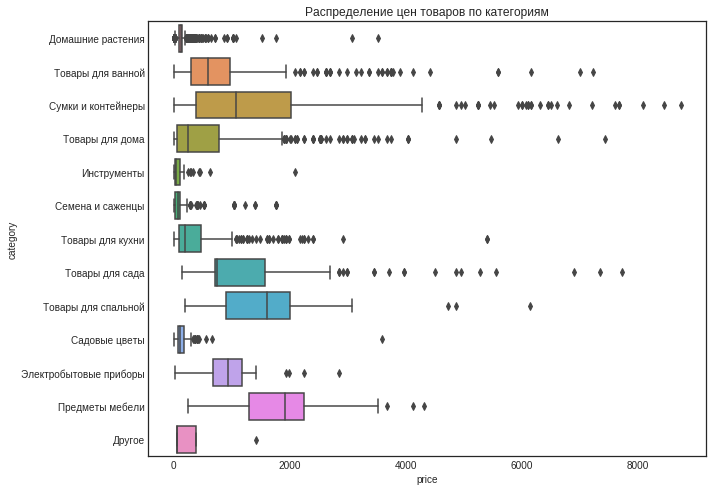

In [42]:
_ = plt.figure(figsize=(10, 8))
_ = sns.boxplot(data=transactions, x='price', y='category')
_ = plt.title('Распределение цен товаров по категориям')

Во всех категориях диапазон цен широкий и есть достаточно много выбросов, что неудивительно, учитывая, что мы выделили только 12 категорий на 2249 товаров. Тем не менее, видно, что по цене категории различаются. Для сборной таблицы возьмем цены по медиане.

В сборную таблицу `by_categories` включим:
- количество уникальных пользователей на категорию - `num_of_customers`, 
- количество уникальных заказов - `num_of_orders`,
- медианную цену отдельно взятого товара в категории - `mdn_product_price`, 
- общую выруску с категории - `evenue_per_category` 
- среднее количество количество товаров на заказ - `avg_prod_quantity`. 

Построим графики, чтобы посмотреть различия.

In [43]:
by_categories = transactions.groupby('category').agg({'customer_id':'nunique', 'order_id':'nunique',
                                                      'price':'median', 'total_price_per_product':'sum', 
                                                      'quantity':'mean'})\
                                .sort_values(by='total_price_per_product', ascending=False)

by_categories = by_categories.rename(columns={'customer_id':'num_of_customers',
                                      'order_id':'num_of_orders',
                                      'price':'mdn_product_price',
                                      'total_price_per_product':'revenue_per_category',
                                      'quantity':'avg_prod_quantity'})

by_categories

,num_of_customers,num_of_orders,mdn_product_price,revenue_per_category,avg_prod_quantity
category,,,,,
Сумки и контейнеры,333,351,1087.0,666331,1.484043
Товары для дома,479,489,247.0,582115,4.078303
Товары для ванной,436,449,599.0,496277,2.560669
Товары для кухни,289,296,204.0,351146,3.814607
Домашние растения,567,624,135.0,343392,1.814644
Товары для сада,143,147,749.0,262954,1.456376
Товары для спальной,15,17,1616.0,111993,3.666667
Семена и саженцы,164,179,89.0,109934,1.529639
Предметы мебели,32,36,1930.5,80337,1.166667


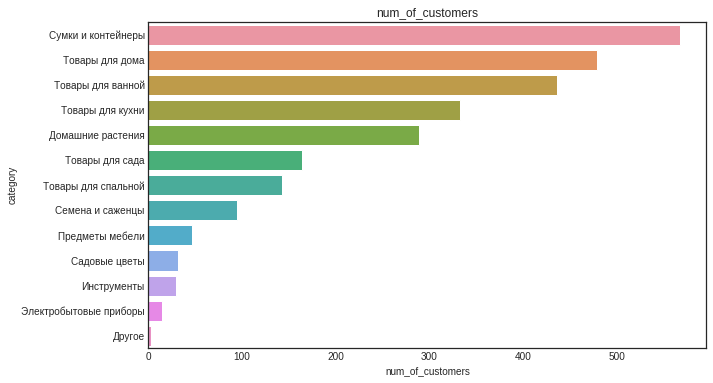

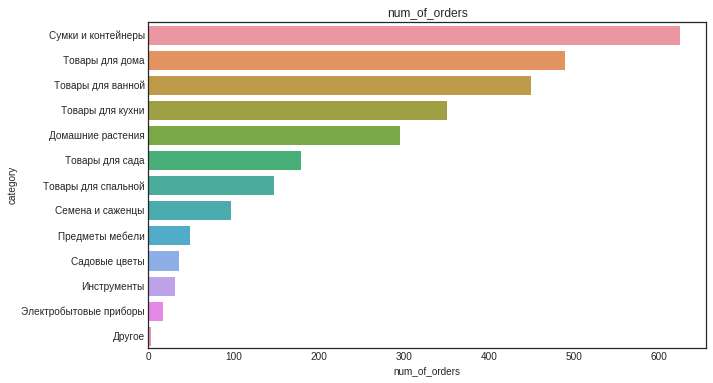

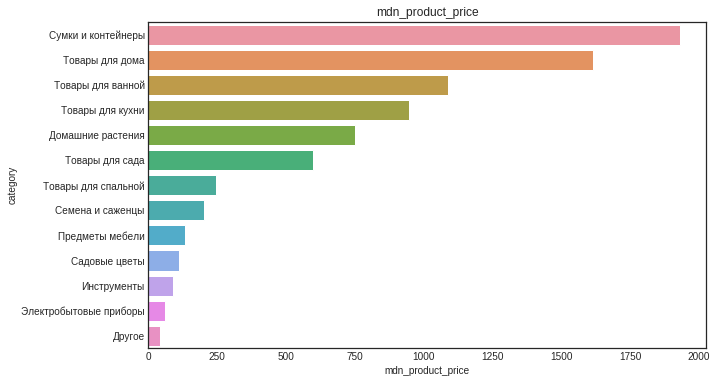

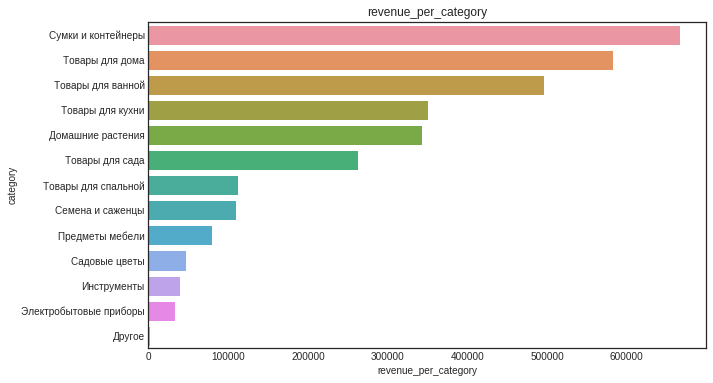

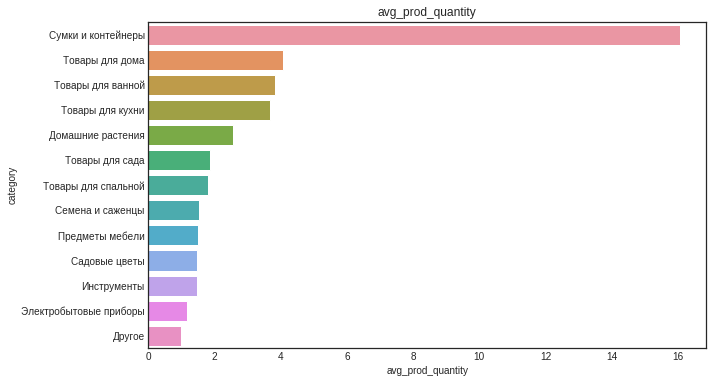

In [44]:
for col in by_categories.columns.to_list():
    _ = plt.figure(figsize=(10, 6))
    _ = sns.barplot(data=by_categories.sort_values(by=col, ascending=False), y=by_categories.index, x=col)
    _ = plt.title(col)
    plt.show()

Итак, несмотря на то, что больше всего заказов и клиентов приходится на категории `Домашние растения` и `Семена и саженцы`, они приносят сравнительно небольшой доход, так как сами товары дешевые. 

Больше всего дохода магазину приносят товары категорий `Сумки и контейнеры` (в два раза больше, чем `Домашние растения`), а также `Товары для дома`	и `Товары для ванной`. 

В среднем самые дорогие товары - в категориях `Предметы мебели` и `Товары для спальной`, но они приносят минимум в 6 раз меньше дохода, чем `Сумки и контейнеры`. Возможно, в магазине хорошего качества сумки и контейнеры, и имеет смысл их больше продвигать в персональных предложениях. Также интересно отметить, что **товары для дома в среднем стоят немногим больше домашних растений, но в итоге приносят почти в два раза больше дохода**. Эту категорию также стоит отмечать в персональных преложениях. 

Теперь сделаем сводную `categories_by_customers` по клиентам и обозначим, в каких категориях они покупали.

In [45]:
categories_by_customers = transactions.pivot_table(index = 'customer_id', columns='category', 
                                    values='order_id', aggfunc='nunique', fill_value=0).reset_index()
categories_by_customers.head()

category,customer_id,Домашние растения,Другое,Инструменты,Предметы мебели,Садовые цветы,Семена и саженцы,Сумки и контейнеры,Товары для ванной,Товары для дома,Товары для кухни,Товары для сада,Товары для спальной,Электробытовые приборы
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,0,0,0,0,0,0,0,0,0,0,0,0
1,001cee7f-0b29-4716-b202-0042213ab038,0,0,0,0,0,0,0,1,0,0,0,0,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,0,0,1,0,0,0,0,0,0,0,0,0,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,0,0,0,0,0,0,1,0,0,0,0,0,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,0,0,0,1,0,0,0,0,0,0,0,0,0


Теперь добавим это к сводной таблице по клиентам - это будет основная таблица -`segmentation`, которую мы используем для кластеризации. Удалим категорию `Другое`, так как там всего 3 клиента.

In [46]:
segmentation = customers.merge(categories_by_customers, on='customer_id')
segmentation = segmentation.drop(['Другое'], axis = 1)
segmentation.head()

,customer_id,num_of_orders,avg_unique_prod,avg_quant_per_order,total_revenue,avg_num_product,avg_product_price,revenue_per_order,Домашние растения,Инструменты,Предметы мебели,Садовые цветы,Семена и саженцы,Сумки и контейнеры,Товары для ванной,Товары для дома,Товары для кухни,Товары для сада,Товары для спальной,Электробытовые приборы
0,000d6849-084e-4d9f-ac03-37174eaf60c4,1,4.0,4.0,555,1.0,138.75,555.0,1,0,0,0,0,0,0,0,0,0,0,0
1,001cee7f-0b29-4716-b202-0042213ab038,1,1.0,1.0,442,1.0,442.00,442.0,0,0,0,0,0,0,1,0,0,0,0,0
2,00299f34-5385-4d13-9aea-c80b81658e1b,1,1.0,2.0,914,2.0,457.00,914.0,0,1,0,0,0,0,0,0,0,0,0,0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1.0,1.0,1649,1.0,1649.00,1649.0,0,0,0,0,0,1,0,0,0,0,0,0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,1,1.0,2.0,2324,2.0,1162.00,2324.0,0,0,1,0,0,0,0,0,0,0,0,0


Готово.

## Вывод <a id="step3.4"></a> 

Итак, мы предположили, что есть сезонность в покупка, но поскольку данные только за год и видна тенденция к уменьшению выручки, а на большинство клиентов приходится только один заказ, мы решили не принимать это во внимание.
Была сделана сводная таблица по клиентам со стобцами:
- количество заказов на каждого клиента, 
- среднее количество уникальных продуктов, 
- среднее количество всех продуктов на заказ, 
- общую выручку по клиенту, 
- среднее количество уникальных продуктов, 
- среднюю стоимость отдельно взятого продукта, 
- среднюю выручку на один заказ. 

Затем мы выделили 12 категорий товаров и добавили информацию, в каких категориях клиенты покупали, к сводной таблице.
Данные готовы к сегментации.

# 3. Сегментация пользователей <a id="step3"></a> 

Построим дендрограмму для определения подходящего количества кластеров. Данные предварительно нормальзуем.

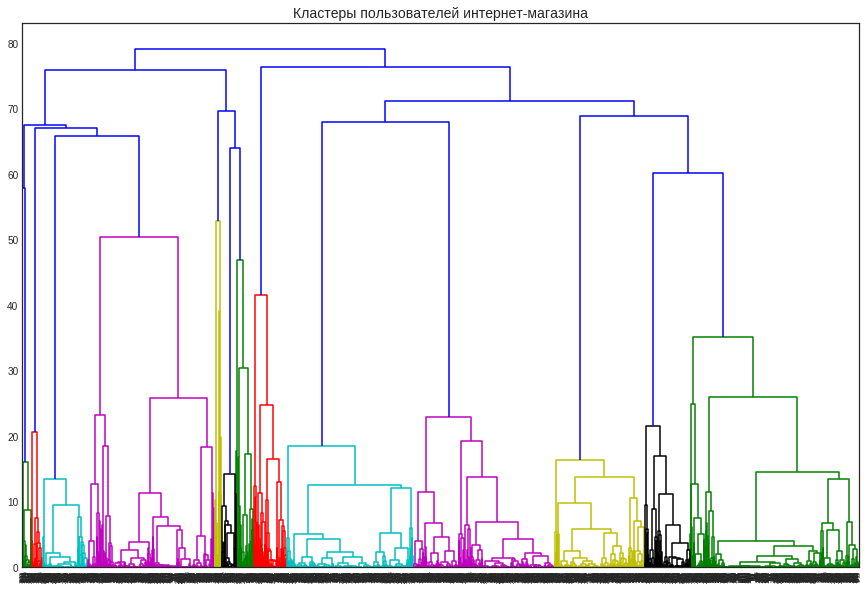

In [47]:
X = segmentation.drop(columns = ['customer_id'], axis = 1)

scaler = StandardScaler()
X_st = scaler.fit_transform(X)

linked = linkage(X_st, method = 'ward')

_ = plt.figure(figsize=(15, 10))  
_ = dendrogram(linked, orientation='top')
_ = plt.title('Кластеры пользователей интернет-магазина', fontsize=14)
plt.show()

Мы видим 13 явных кластеров. Возможно, поскольку в среднем на одного клиента приходится одна категория, категории тут могут быть ведущим признаком. С другой стороны, кластеры получаются очень маленькие, и другие различия между ними могут быть несущественными. Кроме того, поскольку магазин хочет делать персональные преложения, предлагать товары из той же категории - это и так первый очевидный ход. На уровне 70 можно выделить пять кластеров, что предполагает, что клиенты, покупающие разные категории могут быть похожи между собой, и тут можно будет увидеть различия по тому, как они тратят деньги. Поэтому возьмем для сегментации 5 кластеров. 

Применим KMeans для сегментирования пользователей и посмотрим, как они по ним распределились.

In [48]:
model_km = KMeans(n_clusters = 5, random_state = 0)

labels = model_km.fit_predict(X_st)

segmentation['cluster'] = labels

0    1768
2     461
3     115
1      43
4      29
Name: cluster, dtype: int64

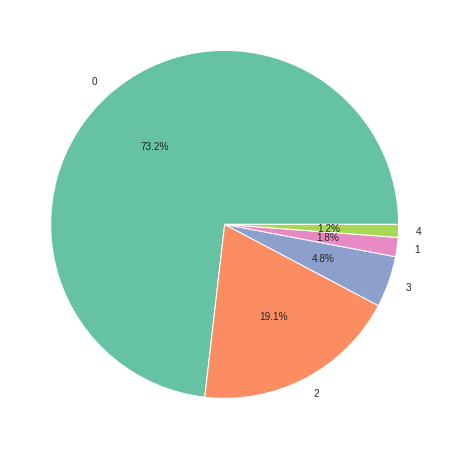

In [49]:
segmentation.cluster.value_counts()
_ = segmentation.cluster.value_counts(normalize=True).plot(kind='pie', autopct='%.1f%%', figsize=(8,8))
_ = plt.ylabel('')

Кластеры неравномерные: 0 - 73%, 1 - 1.8%, 2 - 19%, 3 - 4% и 4 - 1.2%. Посмотрим на общую статистику.

In [50]:
segmentation.groupby('cluster').mean().T

cluster,0,1,2,3,4
num_of_orders,1.067308,1.186047,1.086768,1.260870,1.172414
avg_unique_prod,1.460407,1.193798,1.096529,8.689027,2.000000
avg_quant_per_order,3.178639,6.217054,1.714751,12.195487,76.905172
total_revenue,783.130090,811.093023,2595.982646,1551.426087,11433.482759
avg_num_product,2.495704,5.945736,1.470969,2.586039,66.045567
avg_product_price,480.514536,258.972093,2090.671296,180.262214,397.113946
revenue_per_order,743.353790,595.457364,2434.710114,1309.102671,9083.241379
Домашние растения,0.304299,0.000000,0.008677,0.721739,0.103448
Инструменты,0.000000,1.046512,0.000000,0.000000,0.137931
Предметы мебели,0.000566,0.000000,0.075922,0.000000,0.000000


Как мы и предполагали, в каждом кластере теперь можно выделить более 1 категории. Количественные признаки также показывают, что кластеры сильно отличаются друг от друга. 

Проведем статистическую проверку количественных признаков на значимость, а потом подробнее сравним кластеры между собой и дадим им характеристику. 

# 4. Проверка на статистическую значимость <a id="step4"></a> 

Выделим столбцы с количественными признаками - `quant_col`.

In [51]:
quant_col = ['num_of_orders', 'avg_unique_prod', 'avg_quant_per_order', 'total_revenue', 'avg_num_product',
       'avg_product_price', 'revenue_per_order']

Посмотрим на распределение этих признаков для выбора метода проверки.

In [52]:
for col in quant_col:
    alpha = .05 

    results = st.shapiro(segmentation[col])
    p_value = results[1]
    col
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: распределение не нормально")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

'num_of_orders'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'avg_unique_prod'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'avg_quant_per_order'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'total_revenue'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'avg_num_product'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'avg_product_price'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


'revenue_per_order'

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Все признаки имеют ненормальное распределение. Используем непараметрический U-критерий Манна-Уитни для сравнения выборок между собой. Сформулируем гипотезы:
- H0: между выборками нет статистически значимой разницы
- H1: между выборками есть статистически значимая разница.

Так как у нас 5 кластеров, которые надо сравнить между собой, и 7 признаков, надо будет сделать 70 проверок (10 проверок на один признак). Применим поправку Бонферрони для множественных сравнений: стандратный альфа = 0.05 разделим на 70 => alpha = .0007.

Для проведения проверок напишем две функции: одна сравнивает кластеры между собой - `count_mannwhitneyu`, другая сравнивает все кластеры на одном признаке - `check_metric`. 

In [53]:
def count_mannwhitneyu(cl1, cl2, col):
    
    alpha = .0007 
    results = st.mannwhitneyu(segmentation.query('cluster==@cl1')[col], segmentation.query('cluster!=@cl2')[col])

    print('Кластеры: {} и {}'.format(cl1, cl2))
    print('p-значение: {}'.format(results.pvalue))

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу: разница статистически значима")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя")
    print()

In [54]:
def check_metric(col):
    count_mannwhitneyu(0, 1, col)
    count_mannwhitneyu(0, 2, col)
    count_mannwhitneyu(0, 3, col)
    count_mannwhitneyu(0, 4, col)
    count_mannwhitneyu(1, 2, col)
    count_mannwhitneyu(1, 3, col)
    count_mannwhitneyu(1, 4, col)
    count_mannwhitneyu(2, 3, col)
    count_mannwhitneyu(2, 4, col)
    count_mannwhitneyu(3, 4, col)

Применим функции.

In [55]:
for col in quant_col:
    'Критерий: {}'.format(col)
    check_metric(col)

'Критерий: num_of_orders'

Кластеры: 0 и 1
p-значение: 0.39302425873099434
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 2
p-значение: 0.2010111396376129
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 3
p-значение: 0.45356200829577353
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 4
p-значение: 0.3683983720476711
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 2
p-значение: 0.09384322196826106
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 3
p-значение: 0.05515090298913854
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 4
p-значение: 0.07096317393748262
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 2 и 3
p-значение: 0.16286665540753076
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 

'Критерий: avg_unique_prod'

Кластеры: 0 и 1
p-значение: 0.08139237884322353
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 2
p-значение: 0.0006039035545437107
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 3
p-значение: 0.04039426189117838
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 4
p-значение: 0.0952881224409261
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 2
p-значение: 0.0831928943701239
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 3
p-значение: 0.31537355789988397
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 4
p-значение: 0.15224445902792016
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 2 и 3
p-значение: 4.265407511835649e-06
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 2.3556891492

'Критерий: avg_quant_per_order'

Кластеры: 0 и 1
p-значение: 0.4812149196054704
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 2
p-значение: 0.0003167350071842031
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 3
p-значение: 0.037002463054002406
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 4
p-значение: 0.2963997435256862
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 2
p-значение: 0.012182347075708278
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 3
p-значение: 0.0002353986411753185
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 4
p-значение: 0.0006423085931533296
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 3
p-значение: 6.95876736165987e-16
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 3.139528318747539e-18
Отвергаем нулевую г

'Критерий: total_revenue'

Кластеры: 0 и 1
p-значение: 2.152705814984784e-16
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 2
p-значение: 0.05129863389673881
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 3
p-значение: 2.08700312530279e-12
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 4
p-значение: 4.445712187158576e-13
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 2
p-значение: 0.00014899830956442676
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 3
p-значение: 7.288608874943834e-06
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 4
p-значение: 6.2776677091601745e-06
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 3
p-значение: 1.1784242322500693e-56
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 7.003703150613831e-58
Отвергаем нулевую гипотезу: разница статистически значима

Кл

'Критерий: avg_num_product'

Кластеры: 0 и 1
p-значение: 0.2510651946767556
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 2
p-значение: 0.022538077663369363
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 3
p-значение: 0.16604350619158414
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 4
p-значение: 0.1225670982600266
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 2
p-значение: 0.0007015275838938379
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 1 и 3
p-значение: 4.254265057008722e-05
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 4
p-значение: 2.8133469186939334e-05
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 3
p-значение: 1.753804593107866e-10
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 1.507725315295184e-10
О

'Критерий: avg_product_price'

Кластеры: 0 и 1
p-значение: 2.5045606486651676e-09
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 2
p-значение: 0.013072963443427016
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 3
p-значение: 2.503061950761595e-11
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 4
p-значение: 1.1849805157973303e-08
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 2
p-значение: 1.0403126189568724e-08
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 3
p-значение: 3.5134378198786804e-11
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 4
p-значение: 5.334777348813332e-11
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 3
p-значение: 1.1931246458154072e-76
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 5.563069710530954e-81
Отвергаем нулевую гипотезу: разница статистически значима

'Критерий: revenue_per_order'

Кластеры: 0 и 1
p-значение: 2.344314348088032e-16
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 2
p-значение: 0.06710803663555262
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя

Кластеры: 0 и 3
p-значение: 1.426913410619125e-12
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 0 и 4
p-значение: 6.089570588585729e-13
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 2
p-значение: 4.577650112977894e-05
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 3
p-значение: 1.7947438686687944e-06
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 1 и 4
p-значение: 1.6326909206395996e-06
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 3
p-значение: 5.5152976696289006e-58
Отвергаем нулевую гипотезу: разница статистически значима

Кластеры: 2 и 4
p-значение: 5.100483476358151e-60
Отвергаем нулевую гипотезу: разница статистически значима

К

Итак, видно, что признаками, которые дают наибольшее количество статистически значимой разницы, являются:
- средняя цена продукта - `avg_product_price` (9 значимых из 10), 
- средний чек - `revenue_per_order` (9 значимых из 10), 
- выручка с клиента - `total_revenue` (9 значимых из 10),
- среднее количество товаров в одном заказе - `avg_quant_per_order` (6 значимых из 10).

Количество заказов и уникальных товаров в заказе оказалось не так значимо.

Построим графики для значимых признаков.

In [56]:
segmentation.columns

Index(['customer_id', 'num_of_orders', 'avg_unique_prod',
       'avg_quant_per_order', 'total_revenue', 'avg_num_product',
       'avg_product_price', 'revenue_per_order', 'Домашние растения',
       'Инструменты', 'Предметы мебели', 'Садовые цветы', 'Семена и саженцы',
       'Сумки и контейнеры', 'Товары для ванной', 'Товары для дома',
       'Товары для кухни', 'Товары для сада', 'Товары для спальной',
       'Электробытовые приборы', 'cluster'],
      dtype='object')

In [57]:
quant_col2 = ['avg_product_price', 'revenue_per_order', 'total_revenue', 'avg_quant_per_order']

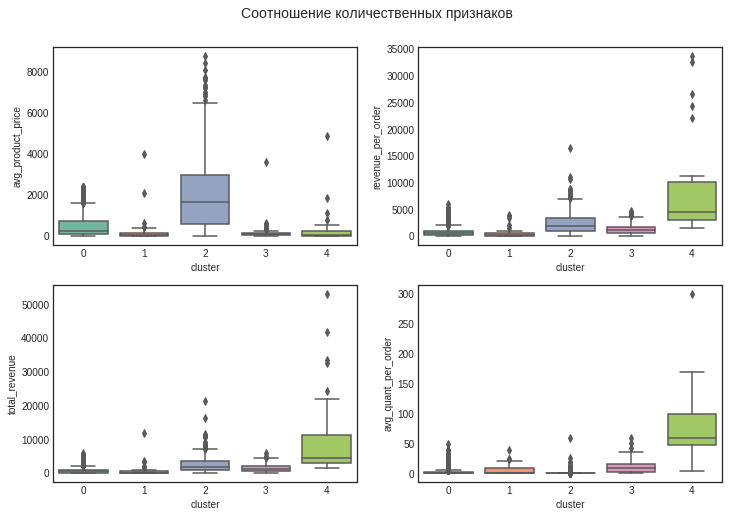

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
_ = fig.suptitle('Соотношение количественных признаков', fontsize=14, y = .95)
for ax, col in zip(axes.flat, quant_col2):
    _ = sns.boxplot(x='cluster', y=col,  data=segmentation,  ax=ax)

plt.show()

Самые дорогие товары берут в кластере 2, но их берут мало, поэтому выручки с таких клиентом также немного.
Больше всего выручки приносит кластер 4, там же берут больше всего товаров в заказе по относительно низкой цене.

Посмотрим, какие категории присутствуют в кластерах.

In [59]:
cat_cols = ['Домашние растения', 'Инструменты', 'Предметы мебели', 'Садовые цветы', 'Семена и саженцы',
            'Сумки и контейнеры', 'Товары для ванной', 'Товары для дома', 'Товары для кухни', 'Товары для сада', 
            'Товары для спальной', 'Электробытовые приборы']

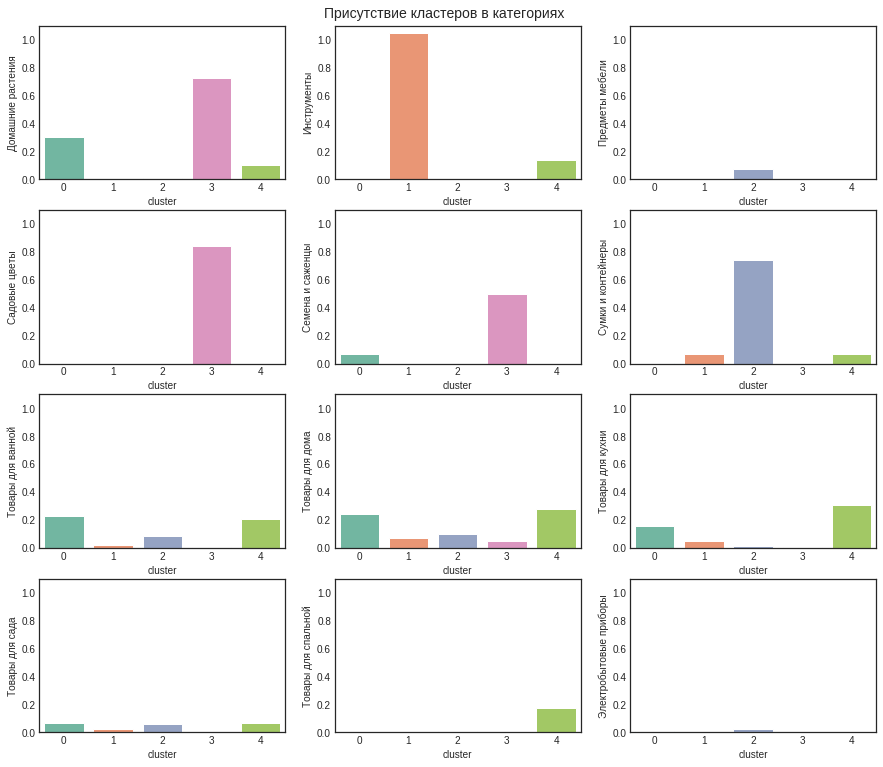

In [60]:
fig, axes = plt.subplots(4,3, figsize=(15,13))
_ = fig.suptitle('Присутствие кластеров в категориях', fontsize=14, y = .9)
for ax, col in zip(axes.flat, cat_cols):
    ratio = segmentation.groupby('cluster')[col].mean().reset_index()
    _ = sns.barplot(x='cluster', y=col, data=ratio,  ax=ax)
    _ = ax.set(ylim = (0,1.1))
    
plt.show()

Так, 
- в кластере 0 берут домашние растения, товары для дома, кухни и ванной,
- в кластере 1 берут в основном инструменты, и немного товаров для дома, для кухни и сумки/контейнеры.
- в кластере 2 основной спрос на сумки и контейнеры, совсем немного на товары для дома, ванной и предметы мебели,
- в кластере 3 берут домашние растения, садовые цветы, семена и саженцы,
- в кластере 4 берут товары 8 категорий, из них больше всего товаров для кухни, дома и ванной.

Выведем еще раз средние значения и дадим характеристику кластерам.

In [61]:
segmentation.groupby('cluster').mean().T

cluster,0,1,2,3,4
num_of_orders,1.067308,1.186047,1.086768,1.260870,1.172414
avg_unique_prod,1.460407,1.193798,1.096529,8.689027,2.000000
avg_quant_per_order,3.178639,6.217054,1.714751,12.195487,76.905172
total_revenue,783.130090,811.093023,2595.982646,1551.426087,11433.482759
avg_num_product,2.495704,5.945736,1.470969,2.586039,66.045567
avg_product_price,480.514536,258.972093,2090.671296,180.262214,397.113946
revenue_per_order,743.353790,595.457364,2434.710114,1309.102671,9083.241379
Домашние растения,0.304299,0.000000,0.008677,0.721739,0.103448
Инструменты,0.000000,1.046512,0.000000,0.000000,0.137931
Предметы мебели,0.000566,0.000000,0.075922,0.000000,0.000000


## Описание сегментов <a id="step4.1"></a> 

**Кластер 0 - обустраивают (украшают) дом по мелочам и покупают разово** 
- 73% клиентов
- большинство берут домашние растения, товары для дома, кухни и ванной,
- маленький средний чек - 783 р. и самый малый доход с клиента - 783 р.,
- в заказе около 3х товаров,
- берут товары примерной стоимости 480 р.

**Кластер 1 - занимаются мелким ремонтом дома**
- 1,7% клиентов, 
- большинство берут инструменты, редко - товары для дома, кухни и сумки/контейнеры,
- самый маленький средний чек - 595 р. и доход с клиента - 783 р.,
- средняя стоимость товара - самая низкая - 258 р.

**Кластер 2 - делают ремонт, потенциально готовы покупать недешевые товары**
- 19% клиентов,
- большинство берут сумки и контейнеры, немного - товары для дома, ванной и предметы мебели,
- в заказе меньше всего предметов - 1.7 среднее,
- средний чек - 2595 р., приносят третий по размеру доход - 2434 р.

**Кластер 3 - любители домашних и садовых растений**
- 4% клиентов,
- берут домашние растения, садовые цветы, семена и саженцы, некоторые берут товары для дома,
- самые дешевые товары - 180 р., но в заказе их может быть много - 12,
- приносят небольшую выручку за счет невысокой стоимости отдельно взятых товаров,

**Кластер 4 - оптовики**
- 1.2% клиентов,
- берут товары из разных категорий, большинство - из товаров для кухни и дома,
- берут недорогие товары -  397 р., но в большом количестве - 76 штук в заказе,
- приносят больше всего прибыли - 9083 р. средний чек и 11433 - общая выручка с клиента. 

# Выводы <a id="step5"></a> 

Данные охватывают период в 13 месяцев. Была обнаружена проблема с датами - на один и тот же заказ приходилось несколько дат. О данной проблеме необходимо сообщить тем, кто собирает статистику на сайте. Выбросов в данных было не очень много, всего было удалено меньше 2% клиентов и около 7% заказов.

Для сегментирования клиентов была составлена по ним сводная таблица и произведена категоризация товаров. Стоит отметить, что большинство клиентов совершили только один заказ за весь период, и в среднем в заказе - 1 товар. Мы выделили 12 категорий:
- Домашние растения,
- Семена и саженцы, 
- Садовые цветы, 
- Товары для кухни, 
- Товары для ванной, 
- Товары для спальной, 
- Электробытовые приборы, 
- Предметы мебели, 
- Товары для дома, 
- Товары для сада, 
- Сумки и контейнеры, 
- Инструменты. 

Анализ показал, что, несмотря на то, что больше всего заказов и клиентов приходится на категории `Домашние растения` и `Семена и саженцы`, они приносят сравнительно небольшой доход, так как сами товары дешевые. Больше всего дохода магазину приносят товары категорий `Сумки и контейнеры` (в два раза больше, чем `Домашние растения`), а также `Товары для дома`	и `Товары для ванной`. Возможно, в магазине хорошего качества сумки и контейнеры, и имеет смысл их больше продвигать в персональных предложениях. Также интересно отметить, что товары для дома в среднем стоят немногим больше домашних растений, но в итоге приносят почти в два раза больше дохода. Эту категорию также стоит отмечать в персональных преложениях. 

## Профили потребления
В итоге клиенты были разделены на 5 групп. Приведем их в порядке численности с краткой характеристикой. Возможными персонализированными предложениями могут быть предложения акционных товаров из главной же категории (выделена курсивом), и просвещение клиентов и специальные предложения по второстепенным категориям. 

**Те, кто обустраивают (украшают) дом по мелочам и покупает разово** (73% клиентов). Берут *домашние растения*, товары для дома, кухни и ванной. Берут товары примерной стоимости 480 р. Делают маленький средний чек - 783 р. Почти не возвращаются.

**Те, кто делают ремонт, потенциально готовы покупать недешевые товары** (19% клиентов). Большинство берут *сумки и контейнеры*, меньше - товары для дома, ванной и предметы мебели. В заказе не больше 2х всего предметов, но средний чек высокий - 2595 р., приносят третий по размеру доход - 2434 р. Это **может быть достаточно перспективный сегмент**.

**Любители домашних и садовых растений** (4% клиентов). Берут *садовые цветы, домашние растения*, семена и саженцы, некоторые берут товары для дома. Эти клиенты берут самые дешевые товары - 180 р., но в заказе их может быть много - 12. Приносят небольшую выручку за счет невысокой стоимости отдельно взятых товаров.


**Те, кто занимаются мелким ремонтом дома** (1,7% клиентов). Берут *инструменты*, редко - товары для дома, кухни и сумки/контейнеры. Самая низкая средняя стоимость товара - 258 р. и самый маленький средний чек - 595 р. Доход с клиента - 783 р.

**Оптовики** (1.2% клиентов). Берут товары из разных категорий, большинство - из *товаров для кухни и дома*. Другие категории - товары для ванной, домашние растения, инструменты, товары для сада. Берут недорогие товары -  397 р., но в большом количестве - среднее 76 штук в заказе. Приносят больше всего прибыли - 9083 р. средний чек и 11433 - общая выручка с клиента. **Возможно, самый перспективный сегмент для вложений, учитывая, что это всего 1,2% клиента и самый большой доход**.